In [1]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind,ranksums

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
orig_df_wb = orig_df[orig_df['pid'].isin(subj_list)]

with open('pkl/emoprox2_dataset_timeseries+inputs_ABA36.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
orig_df_aba = orig_df[orig_df['pid'].isin(subj_list)]

with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

aba_rois = pd.read_csv('/home/joyneelm/emoprox2_slds_bootstrap_resamples/ABA_36ROIs_gm_new.txt',sep='\t')
roi_list = ['ant. ventral Insula','ant. dorsal Insula','mid/post Insula','BST','vmPFC','PAG']
aba_rois = aba_rois[aba_rois.ROI.isin(roi_list)]

max_rois = pd.read_csv('/home/joyneelm/emoprox2_slds_bootstrap_resamples/README_MAX_ROIs_final_gm_85.txt',sep='\t')
roi_list = ['ant. ventral Insula','ant. dorsal Insula','mid/post Insula','BST','vmPFC1','vmPFC2','PAG']
max_rois = max_rois[max_rois.ROI.isin(roi_list)]

# ROI names and network labels for Schaefer 100 ROI atlas
atlas_df = pd.read_csv('https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/freeview_lut/Schaefer2018_100Parcels_17Networks_order.txt',sep='\t',header=None)
atlas_df = atlas_df[[0,1]]
atlas_df.columns = ['idx','name']
atlas_df['name'] = atlas_df['name'].apply(lambda s: s[11:].split('_'))
atlas_df['hemi'] = atlas_df['name'].apply(lambda s: s[0])
atlas_df['network'] = atlas_df['name'].apply(lambda s: s[1])
atlas_df['name'] = atlas_df['name'].apply(lambda s: '_'.join(s[2:]))
atlas_df['idx'] = atlas_df['idx'] - 1

In [3]:

display(aba_rois)

,sHemi,ROI,Index,Voxels,File_Name,Network_name,Network_Ref
14,R,ant. ventral Insula,15,176,Hammers-gm-0.5-anterior_pole_INS-r_2mm.nii.gz,NaN,NaN
15,L,ant. ventral Insula,16,171,Hammers-gm-0.5-anterior_pole_INS-1_2mm.nii.gz,NaN,NaN
16,R,ant. dorsal Insula,17,235,Hammers-gm-0.5-2mm-AntDorsal-INS-r.nii.gz,NaN,NaN
17,L,ant. dorsal Insula,18,236,Hammers-gm-0.5-2mm-AntDorsal-INS-l.nii.gz,NaN,NaN
18,R,mid/post Insula,19,572,Hammers-gm-0.5-2mm-MidPosterior-INS-r.nii.gz,NaN,NaN
19,L,mid/post Insula,20,533,Hammers-gm-0.5-2mm-MidPosterior-INS-l.nii.gz,NaN,NaN
20,R,BST,21,8,rBNST.nii.gz,NaN,NaN
21,L,BST,22,9,lBNST.nii.gz,NaN,NaN
28,R,PAG,29,15,rPAG_Ezra.nii.gz,NaN,NaN
29,L,PAG,30,24,lPAG_Ezra.nii.gz,NaN,NaN


In [4]:

display(max_rois)

,Hemi,ROI,Index,Voxels,File_Name
4,M,vmPFC1,5,67,vmPFC.nii.gz
5,M,vmPFC2,6,81,Hartley_vmPFC_5mm.nii.gz
47,R,ant. ventral Insula,48,176,Hammers-gm-0.5-anterior_pole_INS-r_2mm.nii.gz
48,L,ant. ventral Insula,49,171,Hammers-gm-0.5-anterior_pole_INS-1_2mm.nii.gz
49,R,ant. dorsal Insula,50,235,Hammers-gm-0.5-2mm-AntDorsal-INS-r.nii.gz
50,L,ant. dorsal Insula,51,236,Hammers-gm-0.5-2mm-AntDorsal-INS-l.nii.gz
51,R,mid/post Insula,52,572,Hammers-gm-0.5-2mm-MidPosterior-INS-r.nii.gz
52,L,mid/post Insula,53,533,Hammers-gm-0.5-2mm-MidPosterior-INS-l.nii.gz
53,R,BST,54,8,rBNST.nii.gz
54,L,BST,55,9,lBNST.nii.gz


In [5]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 500
M = 20

In [6]:
from sklearn.cluster import KMeans
from munkres import Munkres
from sklearn.metrics.pairwise import cosine_similarity

def reference_comms(num_states, X):
    X = np.concatenate(X, axis=-1)
    print(X.shape)
    kmeans = KMeans(
        n_clusters=num_states, 
        init='k-means++', n_init=50,
        random_state=74
    ).fit(X=X.T)
    print('found reference')
    return kmeans.cluster_centers_.T # num_rois x num_comms

def align_two_partitions(source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(Dd)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(num_states, X):
    comm_cntrs = reference_comms(num_states, X)
    print(comm_cntrs.shape)
    best_pis = []
    for idx, comms in tqdm(enumerate(X)):
        _, best_pi = align_two_partitions(
            source_comms=comms, 
            target_comms=comm_cntrs
        )
        best_pis.append(best_pi)
    return best_pis

def get_attractors(idx_resample):
    if idx_resample<=100:
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
            model,_,_,_ = pickle.load(f)
    elif idx_resample>100:
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
            model,_,_,_ = pickle.load(f)
    As = model.dynamics.As
    bs = model.dynamics.bs
    C = model.emissions.Cs[0]
    d = model.emissions.ds[0]
    attractors = np.zeros((K,N))
    for k in range(K):
        attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
    attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
    return attractors.T

all_attractors = []    
for idx_resample in tqdm(range(1,1+num_resamples)):
    all_attractors.append(get_attractors(idx_resample))
print(all_attractors[0].shape)

all_perms = align_partitions(K,all_attractors)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [15:45<00:00,  1.89s/it]


(85, 6)
(85, 3000)
found reference
(85, 6)


500it [00:00, 1176.31it/s]


In [7]:
def get_df(idx_resample,perm):

    if idx_resample<=100:
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
            model, q, elbos, resampled_subj_list = pickle.load(f)
    elif idx_resample>100:
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
            model, q, elbos, resampled_subj_list = pickle.load(f)    
        
    model.permute(perm)
    # model.permute(np.array([0, 1, 3, 2, 4, 5]))
    model.permute(np.array([1,0,2,3,4,5])) #500 resamples

    resampled_df = []
    for pid in resampled_subj_list:
        resampled_df.append(orig_df[orig_df['pid']==pid])
    resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)

    resampled_df1 = []
    for pid in resampled_subj_list:
        resampled_df1.append(orig_df_aba[orig_df_aba['pid']==pid])
    resampled_df1 = pd.concat(resampled_df1).reset_index().drop('index',axis=1)

    resampled_df2 = []
    for pid in resampled_subj_list:
        resampled_df2.append(orig_df_wb[orig_df_wb['pid']==pid])
    resampled_df2 = pd.concat(resampled_df2).reset_index().drop('index',axis=1)

    df = resampled_df
    df_aba = resampled_df1
    df_wb = resampled_df2

    df['continuous_states'] = [None]*df.shape[0]
    df['discrete_states'] =[None]*df.shape[0]
    df['timeseries_roi'] = [None]*df.shape[0]

    hrflag=0
    prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    dir_bins = [0]
    nprox = len(prox_bins)+1
    ndir = len(dir_bins)+1
    for idx_row in range(df.shape[0]):
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        proxd = np.digitize(prox, bins=prox_bins)
        dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
        stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
        input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

        y = df.loc[idx_row]['timeseries']
        y_aba = df_aba.loc[idx_row]['timeseries']
        y_wb = df_wb.loc[idx_row]['timeseries']
        x = q.mean_continuous_states[idx_row]
        z = model.most_likely_states(x,y,input=input)
        df.at[idx_row,'continuous_states'] = x
        df.at[idx_row,'discrete_states'] = z
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        df.at[idx_row,'proximity'] = prox

        y_roi = np.zeros((y.shape[0],4))
        y_roi[:,0] = y_aba[:,np.array([16])].mean(axis=1)
        y_roi[:,1] = y_aba[:,np.array([34])].mean(axis=1)
        y_roi[:,3] = y_wb[:,atlas_df[atlas_df.network.isin(['DefaultA','DefaultB','DefaultC'])]['idx'].values].mean(axis=1)
        y_roi[:,2] = y_wb[:,atlas_df[atlas_df.network.isin(['SalVentAttnA','SalVentAttnB'])]['idx'].values].mean(axis=1)
        df.at[idx_row,'timeseries_roi'] = y_roi

    return df

In [8]:
import rle
import random

def get_trans_mat(df,shuffle_z:bool=False):
    PI = np.zeros((K,K))
    for z in df['discrete_states'].values:

        z_perm = z.copy()

        if shuffle_z == True:
            values,counts = rle.encode(z_perm)
            encoding = list(zip(values, counts))
            random.shuffle(encoding)
            values,counts = zip(*encoding)
            z_perm = rle.decode(values=values, counts=counts)

        for st_from,st_to in zip(z_perm[:-1],z_perm[1:]):
            PI[st_from,st_to] += 1
    PI = PI / np.expand_dims(PI.sum(axis=1),axis=1)
    return PI

In [9]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [10]:
all_dfs = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    all_dfs[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))

100%|██████████| 500/500 [1:04:33<00:00,  7.75s/it]


In [11]:
trans_list = ['02','24','43','32','21','10','03','34']


In [12]:
from itertools import cycle

winlen = 8
net_colors = 'mgrbcky'
roi_names = ['right anterior insula','ventromedial PFC','salience network','default network']

def get_transition_responses(y,z,st_i,st_j,win=winlen):
    ret = []
    for t in range(win//2-1,len(z)-win//2):
        if z[t]==st_i and z[t+1]==st_j:
            if np.all(z[t-win//2+1:t+1]==st_i) and np.all(z[t+1:t+win//2+1]==st_j):
                ret.append(y[t-win//2+1:t+win//2+1])
    if len(ret)>0: return np.mean(np.stack(ret,axis=0),axis=0)
    else: return None


def bootstrap_err(sample):
    means = np.zeros(100)
    for i in range(100):
        means[i] = np.random.choice(sample,len(sample),replace=True).mean()
    return means.std()*1.96
def bootstrap_err_matrix(X):
    ret = np.zeros_like(X[0])
    for i in range(X[0].shape[0]):
        for j in range(X[0].shape[1]):
            ret[i,j] = bootstrap_err(X[:,i,j])
    return ret

def get_mean_transition_response(df,state_from,state_to):
    subj_list = df.pid.unique()
    trans_responses = []
    for pid in subj_list:
        count = 0
        df_subj = df[df.pid==pid]
        z_subj = np.hstack(list(df_subj.discrete_states.values))
        y_subj = np.vstack(list(df_subj.timeseries_roi.values))
        y_trans = get_transition_responses(y_subj,z_subj,state_from,state_to)
        if y_trans is not None: trans_responses.append(y_trans)
    trans_responses = np.stack(trans_responses,axis=0)
    mean_trans_response = trans_responses.mean(axis=0)
    std_trans_response = bootstrap_err_matrix(trans_responses)
    return mean_trans_response,std_trans_response



In [20]:
# with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
#     state_masks = pickle.load(f)
# resp = {trans:[] for trans in trans_list}
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     if idx_resample==80:continue
#     df = all_dfs[idx_resample]
#     state_mask = state_masks[idx_resample]
#     count = 0
#     for i in range(K):
#         for j in range(K):
#             if state_mask[i]==1 or state_mask[j]==1: continue
#             if f'{i}{j}' not in trans_list: continue
#             count += 1
#             mean_resp, _ = get_mean_transition_response(df,i,j)
#             resp[f'{i}{j}'].append(mean_resp)
#     if count==8: print(idx_resample)



 27%|██▋       | 133/500 [01:06<03:57,  1.55it/s]

133


 45%|████▍     | 224/500 [01:48<02:29,  1.85it/s]

223


 81%|████████  | 404/500 [03:10<01:12,  1.33it/s]

404


 95%|█████████▍| 473/500 [03:43<00:13,  2.04it/s]

473


100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


In [42]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)
resp = {trans:[] for trans in trans_list}
eresp = {trans:[] for trans in trans_list}
for idx_resample in [404]:
    if idx_resample==80:continue
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    count = 0
    for i in range(K):
        for j in range(K):
            if state_mask[i]==1 or state_mask[j]==1: continue
            if f'{i}{j}' not in trans_list: continue
            count += 1
            mean_resp, err_resp = get_mean_transition_response(df,i,j)
            resp[f'{i}{j}'].append(mean_resp)
            eresp[f'{i}{j}'].append(err_resp)
    if count==8: print(idx_resample)

404


In [43]:
# m = {trans:[] for trans in trans_list}
# e = {trans:[] for trans in trans_list}
# for trans in trans_list:
#     print(len(resp[trans]))
#     trans_responses = np.stack(resp[trans])
#     m[trans] = np.mean(trans_responses,axis=0)
#     e[trans] = bootstrap_err_matrix(trans_responses) #np.std(trans_responses,axis=0)

m = {k:i[0] for k,i in resp.items()}
e = {k:i[0] for k,i in eresp.items()}

In [44]:
state_names = [f'State{i+1}' for i in range(K)]

def plot_line(ax,m,e,idx_roi,label,color):
    ax.plot(m[:,idx_roi],label=label,color=color)
    ax.scatter(np.arange(winlen),m[:,idx_roi],color=color,s=20)
    ax.fill_between(np.arange(winlen),m[:,idx_roi]-e[:,idx_roi],m[:,idx_roi]+e[:,idx_roi],alpha=0.2,color=color)
    ax.axvline(x=winlen//2-0.5,color='k',linestyle='-',linewidth=2)
    ax.axhline(y=0,color='k',linestyle='--',linewidth=2)

def plot_transitions(trans_list,color_list,nrows=3,ncols=3,figsize=(20,10)):
    label_list = [f'{state_names[int(i)//10]}$\mapsto${state_names[int(i)%10]}' for i in trans_list]
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize,sharex=True,sharey=False)
    cycol = cycle('bgrcmk')
    for i,trans in enumerate(trans_list):
        if nrows>1: ax = axs[i//ncols][i%ncols]
        else: ax = axs[i%ncols]
        fr,to = int(trans[0]),int(trans[1])
        # print(m[trans].shape,e[trans].shape)
        for i_net in [0,1,2,3]:#,2,3,4,5]:
            if i==0:
                plot_line(ax,m[trans],e[trans],i_net,roi_names[i_net],net_colors[i_net])
            else:
                plot_line(ax,m[trans],e[trans],i_net,None,net_colors[i_net])
        ax.set_title(label_list[i], fontsize=20)
        if i/ncols==1 and i%ncols==0:
            ax.set_ylabel('Activity(a.u.)',fontsize=20)
            ax.yaxis.set_label_coords(-0.3,1.2)
        if nrows==1 or i//ncols==ncols-1: ax.set_xlabel('Time(TR)',fontsize=15)
        ax.set_xticks(np.arange(winlen))
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.tight_layout(pad=0)
    return fig,axs

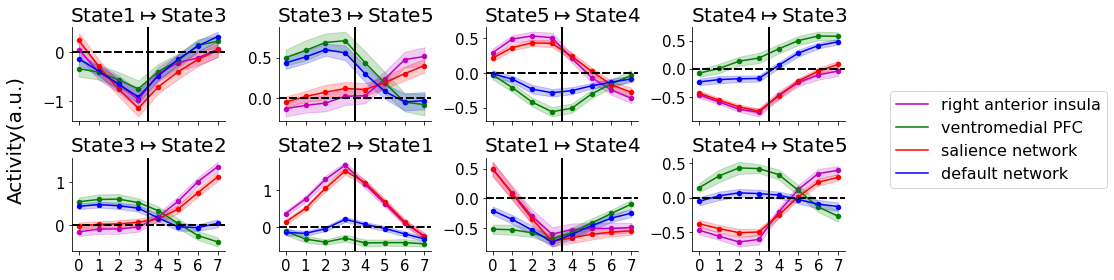

In [45]:

fig,axs = plot_transitions(trans_list,['black'],nrows=2,ncols=4,figsize=(12,4))
# fig.delaxes(axs[1][3])
# fig.delaxes(axs[1][2])
fig.legend(fontsize=16,loc='right',bbox_to_anchor=(1.3, 0.5))
fig.tight_layout()
fig.savefig(f'figures/fig_state_transition_whole_brain_responses_K{K}.jpg',dpi=600,bbox_inches='tight')